## XCEPTION NET ARCHITECTURE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.6.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(224,224),
                                     batch_size=32,class_mode='categorical')

Found 1998 images belonging to 6 classes.


In [4]:
test=ImageDataGenerator(rescale=1./255)
test_data=test.flow_from_directory(directory = 'DATASET/TEST',target_size=(224,224),
                                   batch_size=32,class_mode='categorical')

Found 1998 images belonging to 6 classes.


In [5]:
def xception(input_shape, n_classes):
  
  def conv_bn(x, f, k, s=1, p='same'):
    x = Conv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def sep_bn(x, f, k, s=1, p='same'):
    x = SeparableConv2D(f, k, strides=s, padding=p, use_bias=False)(x)
    x = BatchNormalization()(x)
    return x
  
  
  def entry_flow(x):
    x = conv_bn(x, 32, 3, 2)
    x = ReLU()(x)
    x = conv_bn(x, 64, 3)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, 128, 3)
    x = ReLU()(x)
    x = sep_bn(x, 128, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 128, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = ReLU()(x)
    x = sep_bn(x, 256, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 256, 1, 2)
    
    x = Add()([tensor, x])
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 728, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 728, 1, 2)
    x = Add()([tensor, x])
    
    return x
  
  
  def middle_flow(tensor):
    for _ in range(8):
      x = ReLU()(tensor)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)
      x = ReLU()(x)
      x = sep_bn(x, 728, 3)

      tensor = Add()([tensor, x])
    
    return tensor
  
  
  def exit_flow(tensor):
    x = ReLU()(tensor)
    x = sep_bn(x, 728, 3)
    x = ReLU()(x)
    x = sep_bn(x, 1024, 3)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    
    tensor = conv_bn(tensor, 1024, 1, 2)
    
    x = Add()([tensor, x])
    x = sep_bn(x, 1536, 3)
    x = ReLU()(x)
    x = sep_bn(x, 2048, 3)
    x = ReLU()(x)
    x = GlobalAvgPool2D()(x)
    x = Dense(n_classes, activation='softmax')(x)
  
    return x
  
  
  input = Input(input_shape)
  
  x = entry_flow(input)
  x = middle_flow(x)
  output = exit_flow(x)
  
  model = Model(input, output)
  model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy',tensorflow.keras.metrics.Precision()])
  return model
     

input_shape = 224, 224, 3
n_classes = 6

K.clear_session()
model = xception(input_shape, n_classes)
model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
model_path = "XCEPTION.h5"

from keras.callbacks import ModelCheckpoint

M = ModelCheckpoint(model_path, monitor='accuracy', verbose=1, save_best_only=True)

In [7]:
epochs = 100
batch_size = 512

In [8]:
#### Fitting the model
history = model.fit(
           train_data, steps_per_epoch=train_data.samples // batch_size, 
           epochs=epochs, 
           validation_data=test_data,validation_steps=test_data.samples // batch_size,
           callbacks=[M])

Epoch 1/100
3/3 [==============================] - 148s 50s/step - loss: 1.5353 - accuracy: 0.5000 - precision: 0.6230 - val_loss: 1.7911 - val_accuracy: 0.1771 - val_precision: 0.0000e+00

Epoch 00001: accuracy improved from -inf to 0.50000, saving model to XCEPTION.h5
Epoch 2/100
3/3 [==============================] - 154s 54s/step - loss: 1.7362 - accuracy: 0.5521 - precision: 0.5795 - val_loss: 1.7901 - val_accuracy: 0.2500 - val_precision: 0.0000e+00

Epoch 00002: accuracy improved from 0.50000 to 0.55208, saving model to XCEPTION.h5
Epoch 3/100
3/3 [==============================] - 155s 59s/step - loss: 0.9016 - accuracy: 0.6771 - precision: 0.8194 - val_loss: 1.7944 - val_accuracy: 0.0938 - val_precision: 0.0000e+00

Epoch 00003: accuracy improved from 0.55208 to 0.67708, saving model to XCEPTION.h5
Epoch 4/100
3/3 [==============================] - 221s 76s/step - loss: 0.7649 - accuracy: 0.6771 - precision: 0.7250 - val_loss: 1.7897 - val_accuracy: 0.2083 - val_precision: 0.0

Epoch 34/100
3/3 [==============================] - 183s 74s/step - loss: 0.3746 - accuracy: 0.8542 - precision: 0.8723 - val_loss: 1.7851 - val_accuracy: 0.1979 - val_precision: 0.0000e+00

Epoch 00034: accuracy did not improve from 0.87500
Epoch 35/100
3/3 [==============================] - 148s 52s/step - loss: 0.3975 - accuracy: 0.8438 - precision: 0.8511 - val_loss: 1.8151 - val_accuracy: 0.1562 - val_precision: 0.0000e+00

Epoch 00035: accuracy did not improve from 0.87500
Epoch 36/100
3/3 [==============================] - 163s 57s/step - loss: 0.4232 - accuracy: 0.7917 - precision: 0.8000 - val_loss: 1.8119 - val_accuracy: 0.1250 - val_precision: 0.0000e+00

Epoch 00036: accuracy did not improve from 0.87500
Epoch 37/100
3/3 [==============================] - 137s 48s/step - loss: 0.4898 - accuracy: 0.8229 - precision: 0.8211 - val_loss: 1.7904 - val_accuracy: 0.1562 - val_precision: 0.0000e+00

Epoch 00037: accuracy did not improve from 0.87500
Epoch 38/100
3/3 [==============

In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'val_loss', 'val_accuracy', 'val_precision'])

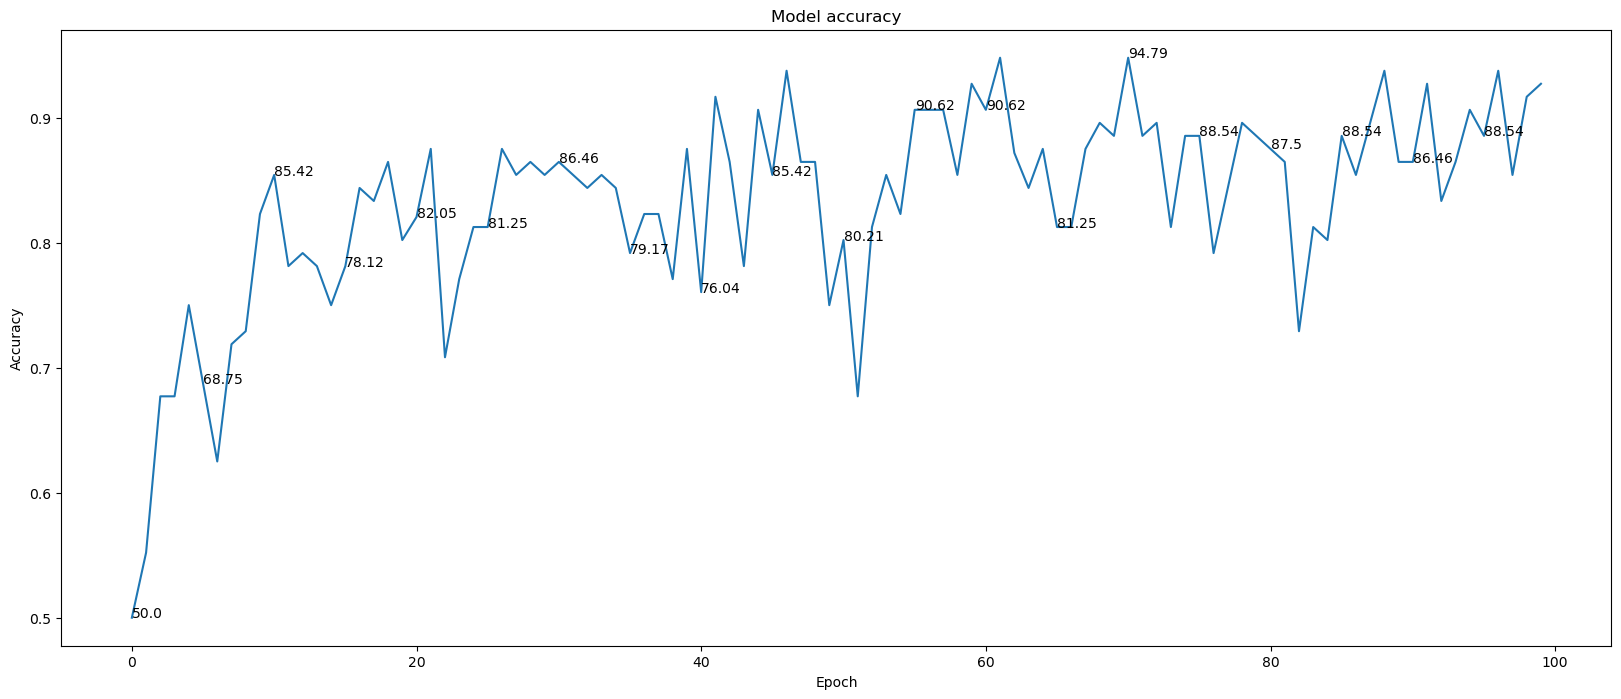

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

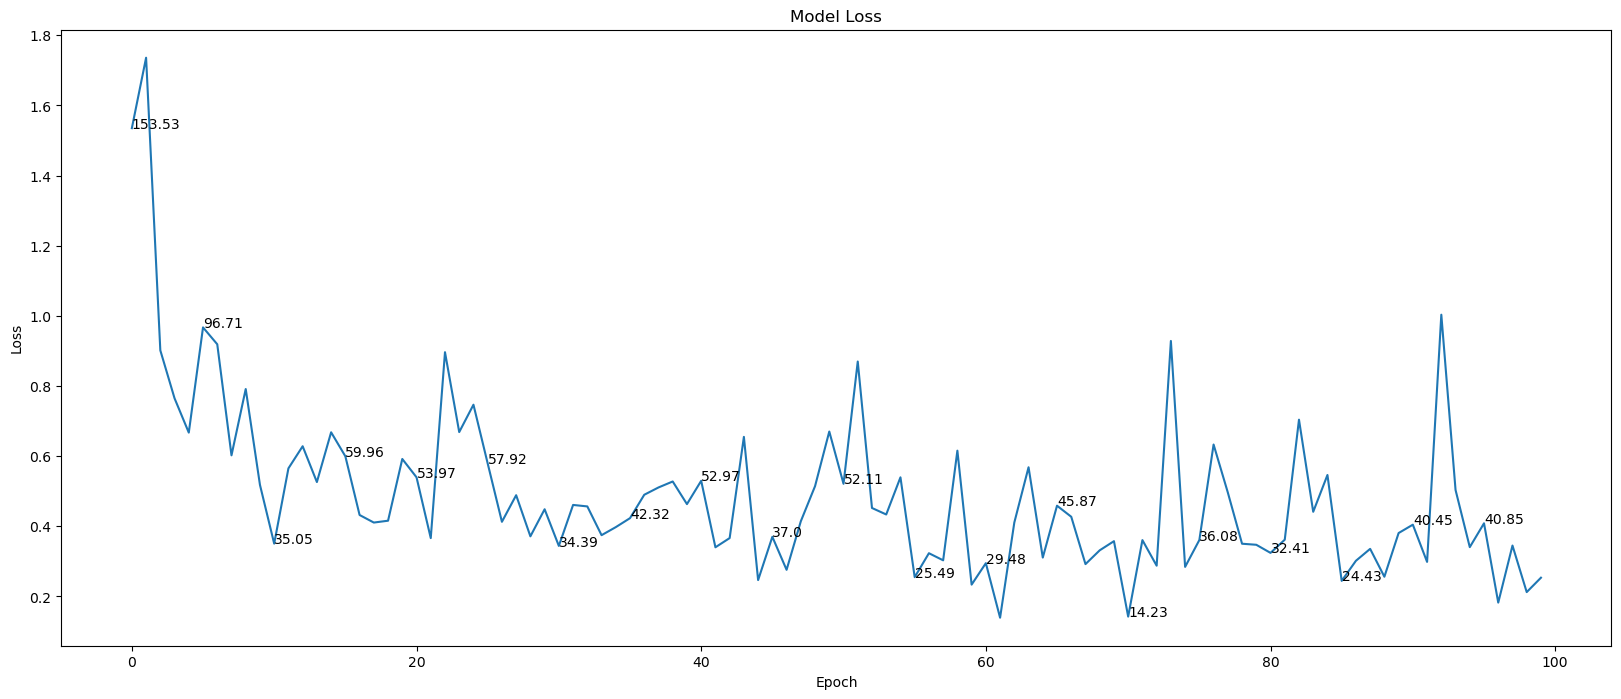

In [11]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()